In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, precision_score,confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import scipy.stats as stat
#from helper import Helper
from urllib.parse import urlparse
import numpy as np
import pickle
import mlflow
import mlflow.sklearn
import scipy.stats as scs
import statsmodels.api as sm

import logging

import dvc.api

In [74]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [75]:
#Get url from DVC

path = r'C:\Users\Jakinda\Documents\Python Scripts\10Academy\ab_mlop\data\os.csv'
repo = r'C:\Users\Jakinda\Documents\Python Scripts\10Academy\ab_mlop'
version = 'v3'

data_url = dvc.api.get_url(

    path = path,
    repo = repo,
    rev = version

)

In [76]:
mlflow.set_experiment('ab_test')

In [77]:
data = pd.read_csv(data_url,sep=',')

In [78]:
mlflow.log_param("data_url", data_url)
mlflow.log_param("data_version", version)
mlflow.log_metric("input_rows", data.shape[0])
mlflow.log_metric("input_cols", data.shape[1])

In [79]:
target_name = "yes"
target = data[target_name]
data = data.drop(columns=target_name)

In [80]:
# 5 folds selected
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
model = LogisticRegression(solver='liblinear')
results = cross_val_score(model, data, target, cv=kfold)
# Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 53.015% (3.328%)


In [81]:
# 5 folds selected
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
model = DecisionTreeClassifier()
results = cross_val_score(model, data, target, cv=kfold)
# Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 51.327% (3.097%)


In [82]:
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size=0.30, random_state=0)

In [83]:
scaler = preprocessing.StandardScaler()
data_train_scaled = scaler.fit_transform(data_train)
data_train_scaled

array([[ 0.92895373,  0.76415145,  1.82713318, -0.68914063,  0.11826248],
       [ 0.92895373,  0.76415145,  1.48024701, -0.68914063,  0.11826248],
       [ 0.92895373,  0.76415145,  1.30680392, -0.68914063,  0.11826248],
       ...,
       [ 0.92895373, -0.82916613,  0.26614542,  2.5474533 ,  0.11826248],
       [-1.07647988,  1.56081023, -0.60107   ,  1.40931038,  0.11826248],
       [ 0.92895373,  1.56081023, -1.81517158,  0.91137285,  0.11826248]])

In [84]:
data_test_scaled = scaler.transform(data_test)
data_test_scaled

array([[ 0.92895373,  1.16248084,  1.13336084, -0.68914063,  0.11826248],
       [-1.07647988, -1.22749552,  0.61303159, -0.68914063,  0.11826248],
       [ 0.92895373,  0.76415145,  1.13336084,  1.19590858,  0.11826248],
       ...,
       [ 0.92895373,  1.16248084,  1.30680392,  0.34230139,  0.11826248],
       [ 0.92895373,  1.16248084, -0.08074075, -0.68914063,  0.11826248],
       [ 0.92895373,  0.76415145, -1.12139925, -0.68914063,  0.11826248]])

In [85]:
def eval_metrics(y_test, y_preds):
    accuracy = accuracy_score(target_test,y_preds)
    f1 = f1_score(target_test,y_preds)
    confusion = confusion_matrix(target_test,y_preds)
    precision = precision_score(target_test,y_preds)
    return accuracy, f1, confusion,precision


In [ ]:
'''def get_p_values(X,Y):
        """ 
        Calcualting p_values for logestic regression.
        code refered from the following link
        https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
        
        """
        denom = (2.0*(1.0+np.cosh(self.clf.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.clf.coef_[0]/sigma_estimates # z-score 
        p_values = [stat.norm.sf(abs(x)) for x in z_scores] ### two tailed test for p-values
        
        p_df = pd.DataFrame()
        p_df['features'] = self.X_train.columns.to_list()
        p_df['p_values'] = p_values
        
        return p_df
        
    
def plot_pvalues(self, p_df):
    
            
    fig, ax = plt.subplots(figsize=(12,7))

    ax.plot([0.05,0.05], [0.05,5])
    sns.scatterplot(data=p_df, y='features', x='p_values', color="green")
    plt.title("P values of features", size=20)

    plt.xticks(np.arange(0,max(p_df['p_values']) + 0.05, 0.05))

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()
    return fig'''

In [86]:
'''import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize=(10,5))
    original = plt.scatter(np.arange(1, N+1), y_test, c='blue')
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c='red')
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('# Oberservation')
    plt.ylabel('Enrollments')
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title)
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()'''

## Logistic Regression 

In [87]:
if __name__ == "__main__":

    model = LogisticRegression(solver='liblinear')
    model.fit(data_train_scaled,target_train)
    
    y_preds = model.predict(data_test_scaled)
    (accuracy, f1, confusion,precision)=eval_metrics(target_test, y_preds)

    print("accuracy: %s" % accuracy)
    print("f1: %s" % f1)
    print("precision: %s" % precision)
    print("confusion: %s" % confusion)

    
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("precision", precision)
    #mlflow.log_metric('confusion_positive',confusion)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
    if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(model, "LogisticRegression", registered_model_name="LogisticRegression")
    else:
        mlflow.sklearn.log_model(model, "LogisticRegression")
        print("Model saved in run %s" % mlflow.active_run().info.run_uuid)

accuracy: 0.5254691689008043
f1: 0.2834008097165992
precision: 0.4375
confusion: [[161  45]
 [132  35]]
Model saved in run f10ce2b3bf8948e0b98d1e70e1aea96f


In [88]:
! mlflow ui

^C


In [97]:
importances = pd.DataFrame(data={
    'Attribute': data_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

,Attribute,Importance
2,hour,0.166765
0,experiment,0.088519
4,platform_os,0.066174
3,device_make,0.031421
1,date,-0.022409


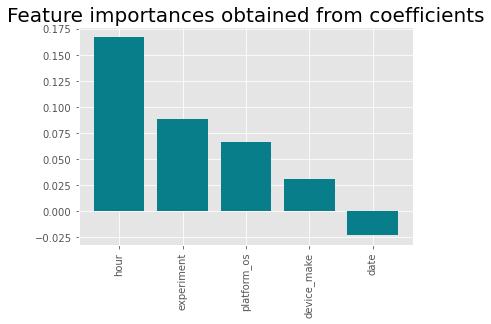

In [67]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [68]:
from sklearn.metrics import classification_report
print(classification_report(target_test, y_preds))

              precision    recall  f1-score   support

           0       0.55      0.78      0.65       206
           1       0.44      0.21      0.28       167

    accuracy                           0.53       373
   macro avg       0.49      0.50      0.46       373
weighted avg       0.50      0.53      0.48       373



In [89]:
mlflow.end_run()

## Decision tree

In [90]:
if __name__ == "__main__":

    dtree = DecisionTreeClassifier(max_depth=5, min_samples_leaf =4, random_state=7)
    dtree.fit(data_train_scaled, target_train)
    y_preds = dtree.predict(data_test_scaled) 
    
    (accuracy, f1, confusion,precision)=eval_metrics(target_test, y_preds)

    print("accuracy: %s" % accuracy)
    print("f1: %s" % f1)
    print("precision: %s" % precision)
    print("confusion: %s" % confusion)

    
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("precision", precision)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
    if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(dtree, "DecisionTreeclassifier", registered_model_name="DecisionTreeclassifier")
    else:
        mlflow.sklearn.log_model(dtree, "DecisionTreeclassifier")
        print("Model saved in run %s" % mlflow.active_run().info.run_uuid)

accuracy: 0.546916890080429
f1: 0.3670411985018726
precision: 0.49
confusion: [[155  51]
 [118  49]]
Model saved in run 08840fb1747f4c53965ffc4c69945908


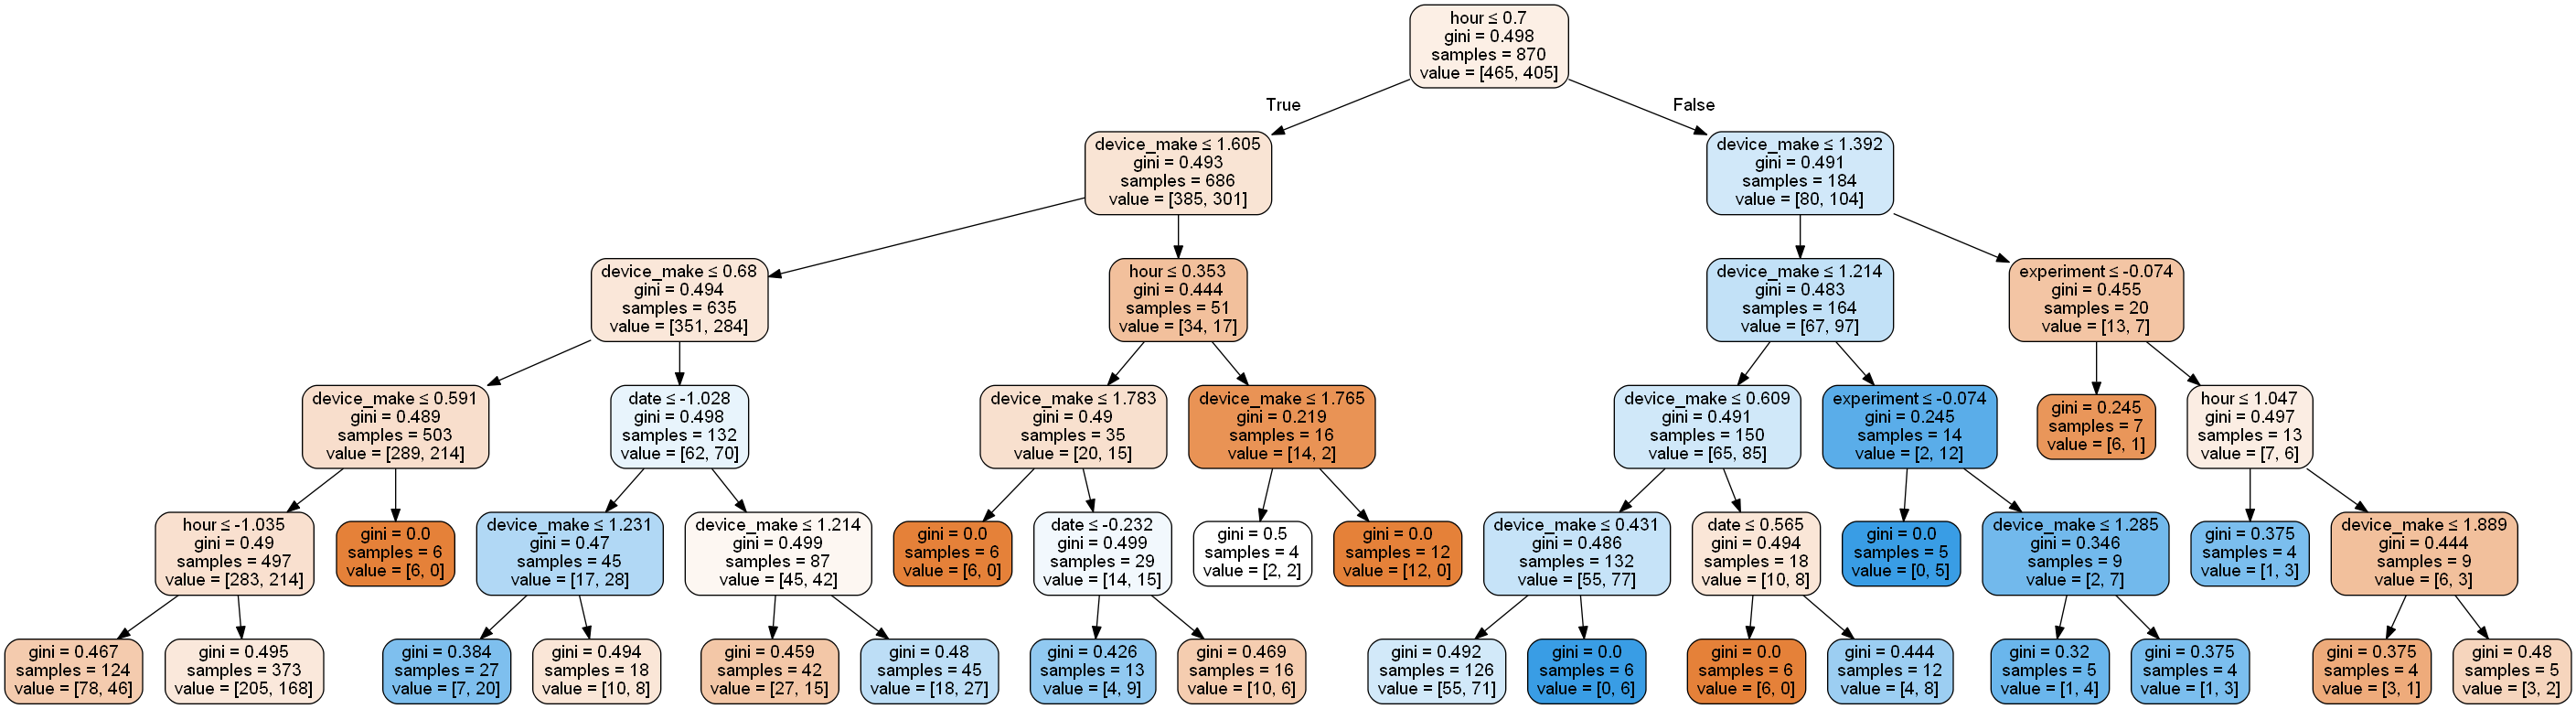

In [91]:
dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data, 
                feature_names=data_train.columns,
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

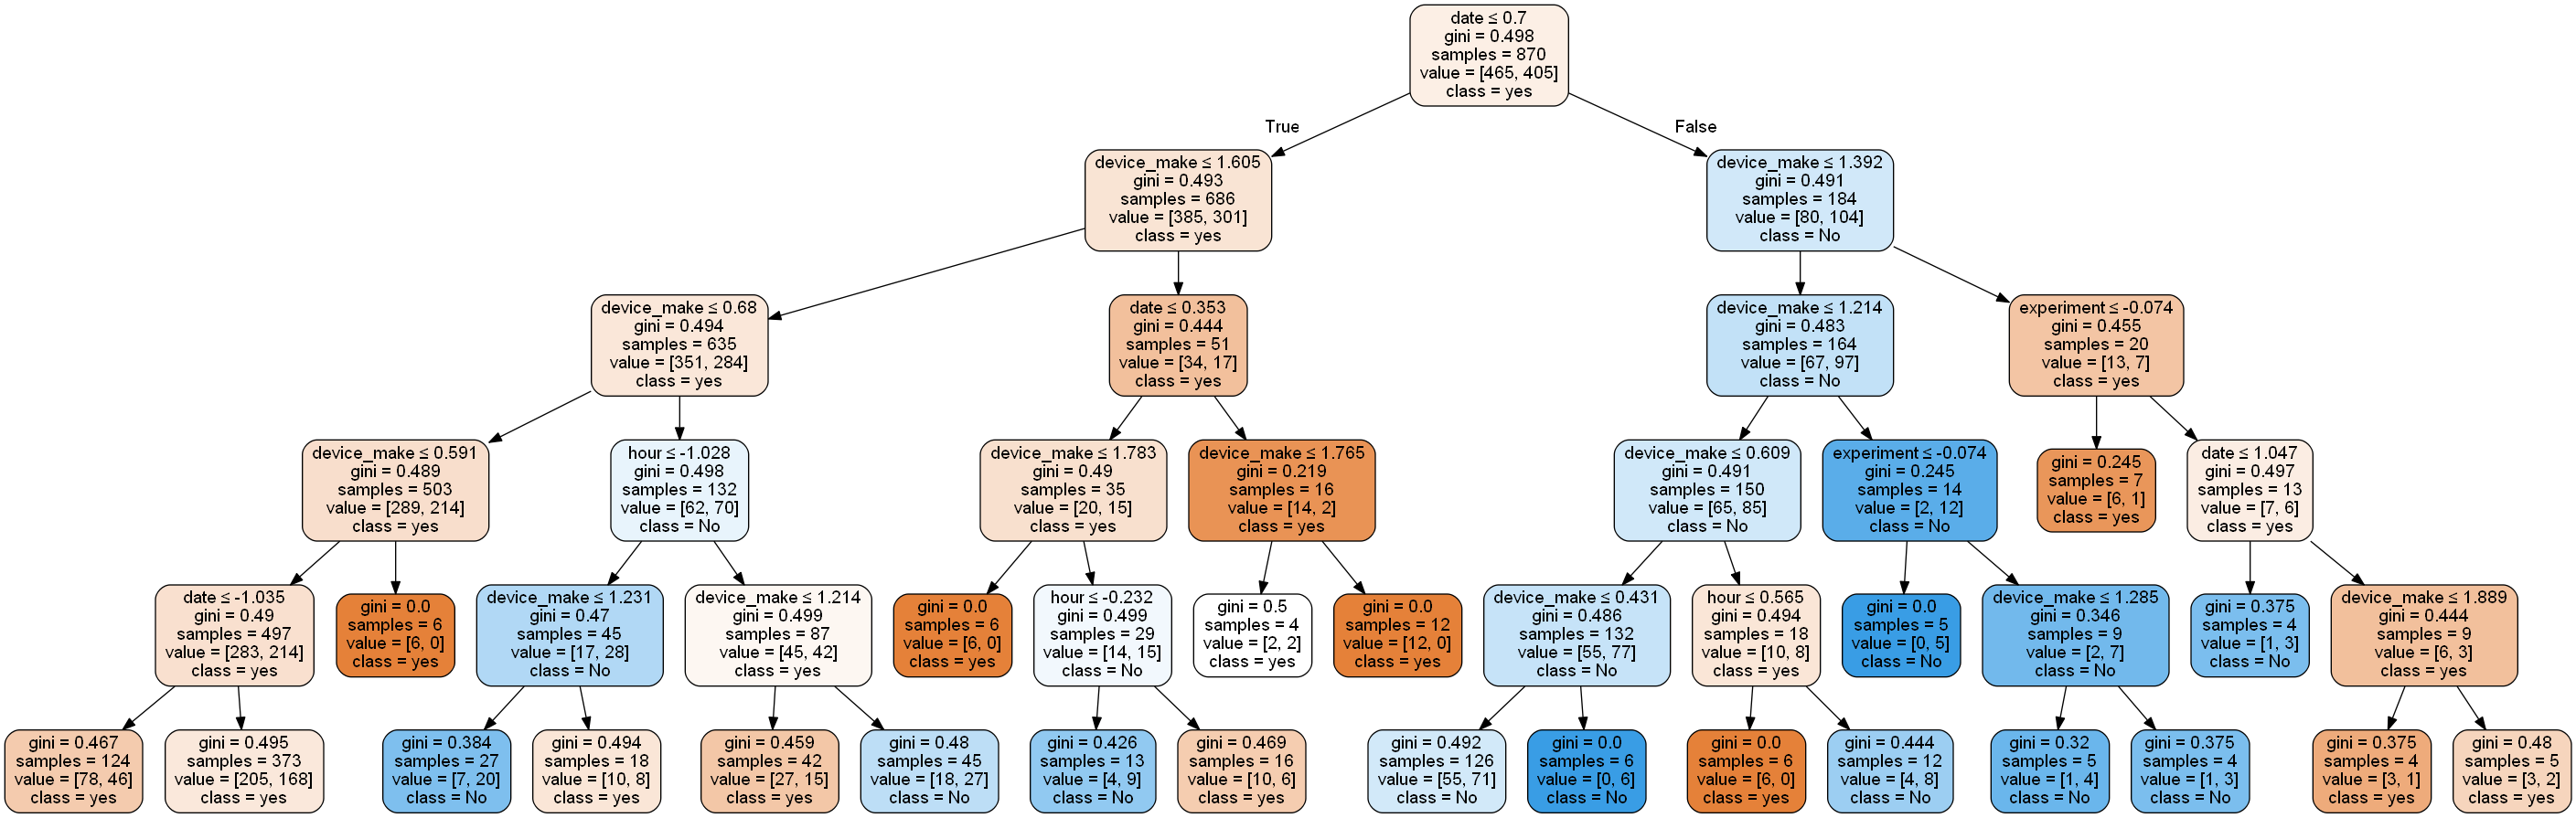

In [100]:

dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(dtree, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['yes','No'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')

Image(graph.create_png())

In [116]:
importances = pd.DataFrame({
    'Feature': data.columns,
    'Importance': dtree.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
device_make,0.570220
hour,0.233516
date,0.163312
experiment,0.032952
platform_os,0.000000


<AxesSubplot:xlabel='Feature'>

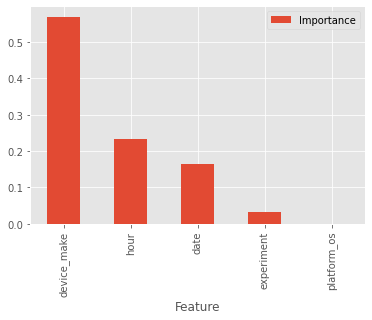

In [121]:
importances.plot.bar()

## XGBOOSTCLASSIFIER 

In [125]:
import time
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(data_train_scaled, target_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(data_test_scaled)
prediction_end = time.perf_counter()
acc_xgb = (preds == target_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

C:\Users\Jakinda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost's prediction accuracy is: 50.94
Time consumed for training: 0.176
Time consumed for prediction: 0.00771 seconds


In [103]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, data_train_scaled, target_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

C:\Users\Jakinda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jakinda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jakinda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jakinda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jakinda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores: [0.51149425 0.52873563 0.54597701 0.57471264 0.5       ]
Mean: 0.532183908045977
Standard Deviation: 0.02636171250845911


In [124]:
importances = pd.DataFrame({
    'Feature': data.columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
experiment,0.273831
date,0.251397
hour,0.237804
device_make,0.236968
platform_os,0.000000


In [129]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

xgboost.fit(data_train_scaled, target_train)
preds = xgboost.predict(data_train_scaled)

accuracy = (preds == target_train).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

C:\Users\Jakinda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost's prediction accuracy WITH optimal hyperparameters is: 66.32


In [128]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, data_train_scaled, target_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

C:\Users\Jakinda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jakinda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jakinda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jakinda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jakinda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores: [0.51149425 0.52873563 0.54597701 0.57471264 0.5       ]
Mean: 0.532183908045977
Standard Deviation: 0.02636171250845911
